In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import peakutils
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 15]

In [46]:
Hay_data_train = pd.read_excel('Hay_ensile_data/DL_ENsH_CP_train_1.xlsx')
Hay_data_val = pd.read_excel('Hay_ensile_data/validation.xlsx')


In [47]:
def convert_abs(input):
    for i in range(input.shape[0]):
        input.iloc[i] = 2-np.log10(input.iloc[i])
    return input


In [69]:
CP = Hay_data_train['CP']
sample_ID = Hay_data_train['Sample ID']
scanner_ID = Hay_data_train['Scanner ID']
spectra_ref = Hay_data_train.drop(['Scanner ID','Sample ID','CP'],axis=1)
wav = spectra_ref.keys().astype(str)
spectra_ref.columns =wav

In [70]:
CP_test = Hay_data_val['CP']
sample_ID_test = Hay_data_val['sampleID']
Scanner_Id  = Hay_data_val['scannerID']
spectra_ref_test = Hay_data_val.drop(['scannerID','sampleID','CP'],axis=1)
spectra_ref_test.columns =wav

In [87]:
spectra_abs =  convert_abs(spectra_ref.copy(deep=True))
spectra_abs_test = convert_abs(spectra_ref_test.copy(deep=True))
spectra_abs.columns = wav
spectra_abs_test.columns = wav

In [88]:
"""
spectra_abs = np.gradient(spectra_abs.copy(deep=True).to_numpy(),axis=1)
spectra_abs = pd.DataFrame(spectra_abs,columns=wav)
spectra_abs_test = np.gradient(spectra_abs_test.copy(deep=True).to_numpy(),axis=1)
spectra_abs_test = pd.DataFrame(spectra_abs_test,columns=wav)
spectra_abs_test.iloc[0].plot()
spectra_abs.iloc[0].plot()
"""

'\nspectra_abs = np.gradient(spectra_abs.copy(deep=True).to_numpy(),axis=1)\nspectra_abs = pd.DataFrame(spectra_abs,columns=wav)\nspectra_abs_test = np.gradient(spectra_abs_test.copy(deep=True).to_numpy(),axis=1)\nspectra_abs_test = pd.DataFrame(spectra_abs_test,columns=wav)\nspectra_abs_test.iloc[0].plot()\nspectra_abs.iloc[0].plot()\n'

In [89]:

def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
 
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
 
    return output_data

In [90]:
spectra_snv = snv(spectra_abs.copy(deep=True).to_numpy())
spectra_snv = pd.DataFrame(spectra_snv,columns=wav)
spectra_snv_test = snv(spectra_abs_test.copy(deep=True).to_numpy())
spectra_snv_test = pd.DataFrame(spectra_snv_test,columns=wav)

<AxesSubplot:>

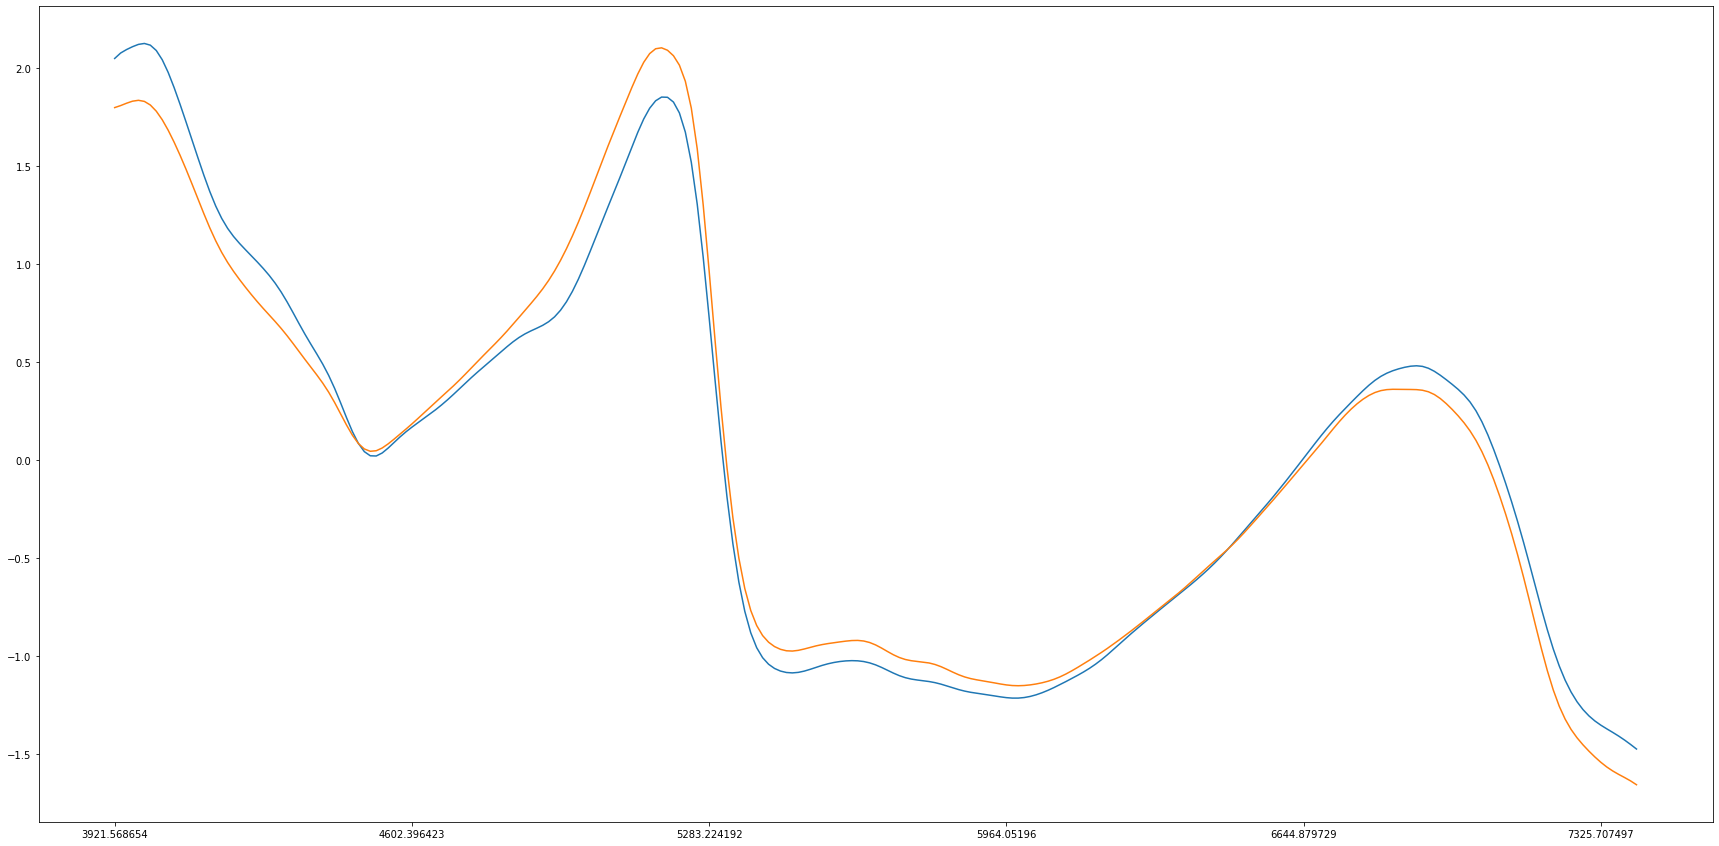

In [92]:
spectra_snv.iloc[0].plot()
spectra_snv_test.iloc[0].plot()

In [132]:
pls = PLSRegression(n_components=20)
scores = cross_val_score(pls,spectra_snv,CP,cv=5,scoring='r2')
np.mean(scores)

-0.15972685310687318

In [133]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
 
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
 
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
 
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
 
    return (data_msc, ref)

In [136]:
spectra_msc,r = msc(spectra_abs.copy(deep=True).to_numpy())
spectra_msc = pd.DataFrame(spectra_msc,columns=wav)
spectra_msc_test,_ = msc(spectra_abs_test.copy(deep=True).to_numpy())
spectra_msc_test = pd.DataFrame(spectra_msc_test,columns=wav)

In [137]:
pls = PLSRegression(n_components=20)
scores = cross_val_score(pls,spectra_msc,CP,cv=5,scoring='r2')
np.mean(scores)

-0.16470230417395104